# Salary predictions using Multivariate Linear Regression 

In this notebook we are predicting employee salaries taking into account a set of features with high corrections to the response variable, we are using multiple linear regression for this project.  

### Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import pearsonr
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
%matplotlib inline

### Global Settings

In [2]:
sns.set(rc={'figure.figsize':(12,8), 'axes.titleweight':'bold', 'axes.labelweight':'bold'}, font_scale = 2)

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('../data/salary.csv')

In [4]:
df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.describe()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,field,yearsabs
count,513.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,50863.220098,2.926070,12.852140,7.052529,0.948521,0.964981,0.044747,2.132296,0.750973,2.529183,6.982490
std,12685.132358,4.791397,9.444695,6.414771,0.149380,0.184008,0.206950,0.820075,0.432871,1.127420,16.873156
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000
50%,50096.000000,0.500000,12.000000,5.000000,0.920000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000
75%,60345.000000,4.000000,22.000000,12.000000,1.020000,1.000000,0.000000,3.000000,1.000000,4.000000,2.000000
max,96156.000000,25.000000,41.000000,28.000000,1.330000,1.000000,1.000000,3.000000,1.000000,4.000000,118.000000


### Insights on measures of central tendency and dispersion on numerical features:

#### Salary feature:
- We can see that the mean is higher than the median. That could simply mean that the distribution is positively skewed and might contain some extreme values.
- The standard deviation is large, this suggests that the data is spread out around the mean.

#### Years of experience:
- The mean is greater than the median this implies a negatively skewed distribution and might contain outliers.
- The standard deviation is relatively low, which means the data points are clustered around the mean

#### Years worked feature:
- We see that the mean is almost equal to the median but it is a bit greater. That can mean that the distribution is slightly close to being a normal distribution.
- The data is centered around the mean as we can see that the standard deviation is a bit low at 9.44.

#### Years absent feature:
- There are extreme values in the data as it shows that the maximum number of years absent is 118. Since we know that it is rather impossible that anyone can be absent from work for 118 years, this could be an error.
- The data points are clustured around the mean and the mean is greater than the median which implies that the distribution is negatively skewed.

#### Years rank feature: 
- The mean greater than the median which could imply that the distribution is negatively skewed.
- the data is centered around the mean since the standard deviation is relatively low at 6.41    


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary       513 non-null    float64
 1   exprior      514 non-null    int64  
 2   yearsworked  514 non-null    int64  
 3   yearsrank    514 non-null    int64  
 4   market       514 non-null    float64
 5   degree       514 non-null    int64  
 6   otherqual    514 non-null    int64  
 7   position     514 non-null    int64  
 8   male         514 non-null    int64  
 9   field        514 non-null    int64  
 10  yearsabs     514 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 44.3 KB


### Checking for missing values

In [8]:
df.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
field          0
yearsabs       0
dtype: int64

Since there is a missing entry in the salary column, we will fill the missing value with the mean.

In [9]:
df = df.fillna(df.mean())

In [10]:
df.isnull().sum()

salary         0
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
field          0
yearsabs       0
dtype: int64

### Checking correlations

Text(0.5, 1.0, 'Correlations to Salary')

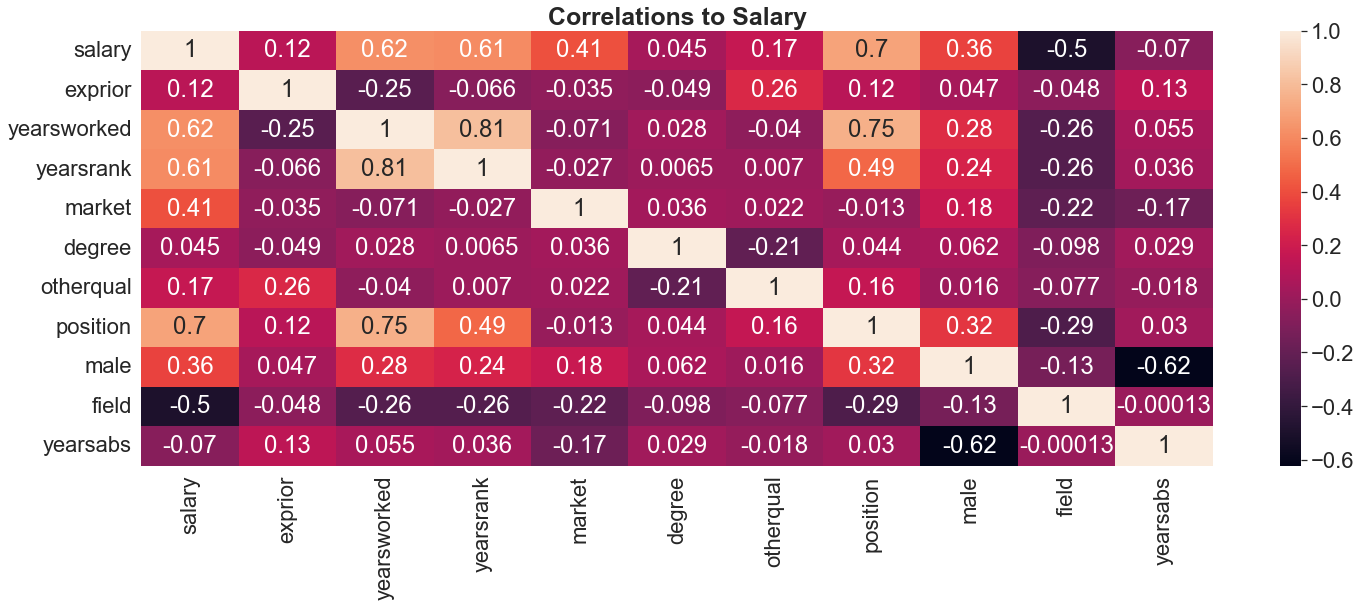

In [11]:
plt.figure(figsize=(24,8))
sns.heatmap(df.corr(), cmap="rocket", annot=True)
plt.title('Correlations to Salary',size=25)

Looking at the heatmap, yearsworked, position, yearsrank and field, are the four characteristics capable of influencing employees' salaries based on the correlations of which the R-squared value is 0.5 and above. Anything less than 0.5 is considered less significant. 

### Dropping characteristics with low correlation

In [12]:
df1 = df.drop(df[['exprior', 'market', 'degree', 'otherqual', 'male', 'yearsabs']], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary       514 non-null    float64
 1   yearsworked  514 non-null    int64  
 2   yearsrank    514 non-null    int64  
 3   position     514 non-null    int64  
 4   field        514 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 20.2 KB


### Below are the histograms of each characteristic

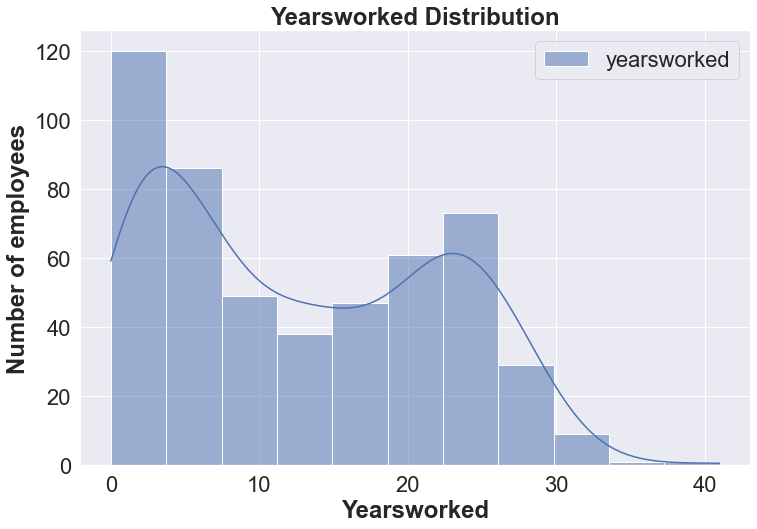

In [13]:
ax = sns.histplot(df[['yearsworked']], kde=True, color='black')
ax.set(xlabel='Yearsworked', ylabel='Number of employees', title="Yearsworked Distribution")
plt.show()

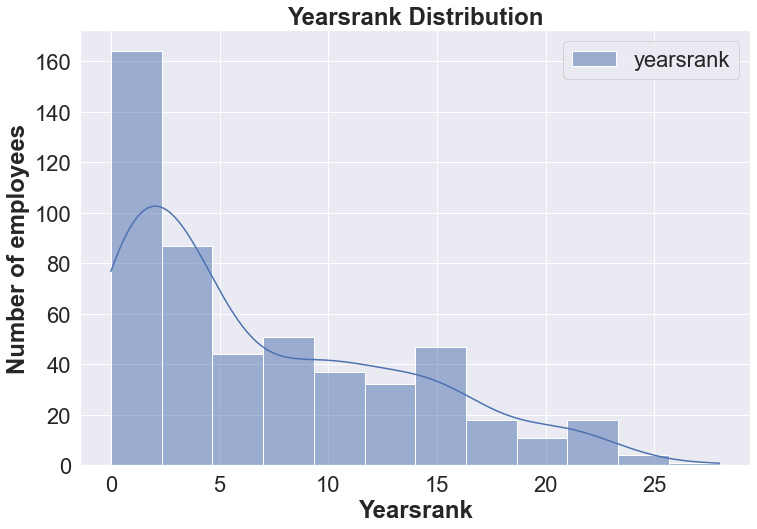

In [14]:
ax = sns.histplot(df[['yearsrank']], kde=True, color='black')
ax.set(xlabel='Yearsrank', ylabel='Number of employees', title="Yearsrank Distribution")
plt.show()

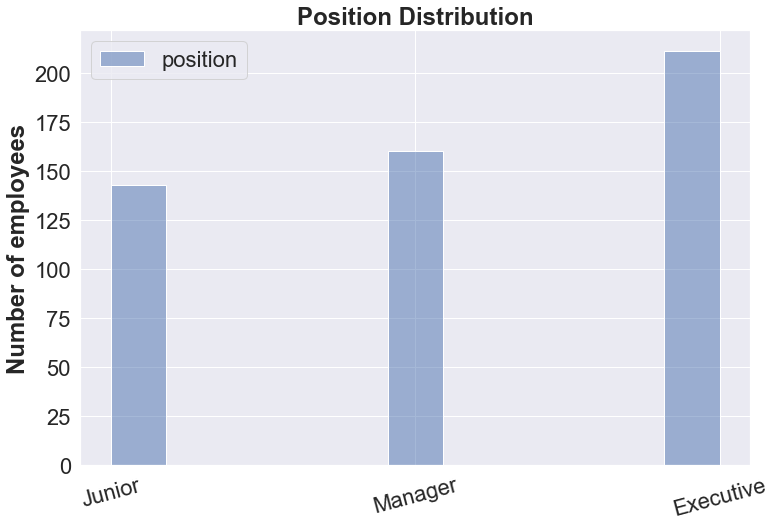

In [15]:
ax = sns.histplot(df[['position']], color='black')
ax.set_xticks(range(1,4))
ax.set_xticklabels(['Junior','Manager','Executive'], rotation=15)
ax.set(ylabel='Number of employees', title="Position Distribution")
plt.show()

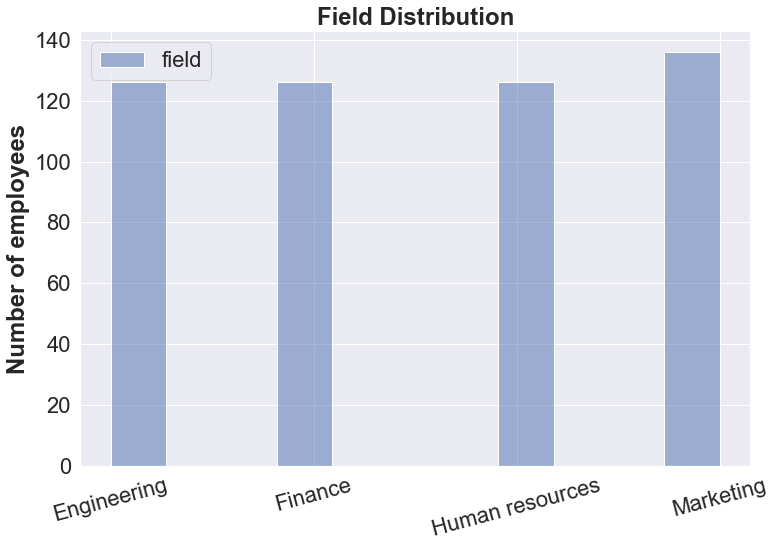

In [16]:
ax = sns.histplot(df[['field']], color='black')
ax.set(ylabel='Number of employees', title="Field Distribution")
ax.set_xticks(range(1,5))
ax.set_xticklabels(['Engineering', 'Finance', 'Human resources', 'Marketing'], rotation=15)
plt.show()

### Insights

Since we saw that features with high correlations are yearsworked, yearsrank, position and field, we can also deduce from the distributions that yearsworked and yearsrank have a postively skewed distribution while position is skewed to the left, field has a slightly normal distribution. However position and Field are categorical features, they will be dealt with going forward as we perform feature engineering.

Noticing that we did not address the salary feature, we will go ahead and look at it after looking at the relationship between salary and categorical features below since it makes sense to relate them to our response variable.

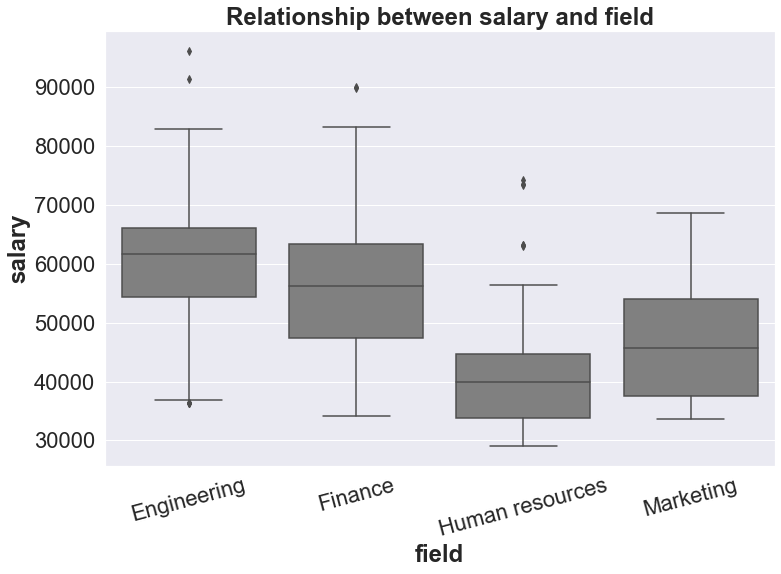

In [17]:
ax = sns.boxplot(x=df['field'], y=df['salary'], color='grey')
ax.set_xticklabels(['Engineering', 'Finance', 'Human resources', 'Marketing'], rotation=15)
ax.set(title="Relationship between salary and field")
plt.show()

From this boxplot it is clear that engineering field has higher salaries than other fields while HR has the lowest salaries compared to the rest of the fields. There are oultiers across all fields except Marketing.

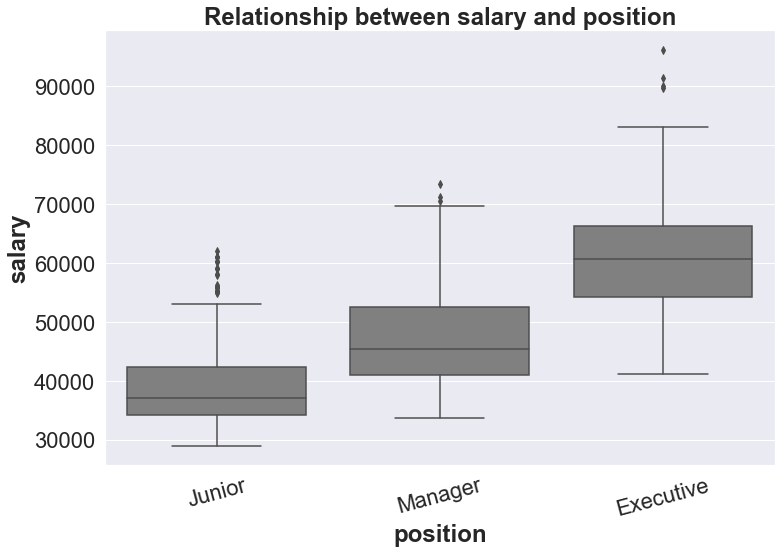

In [18]:
ax = sns.boxplot(x=df['position'], y=df['salary'], color='grey')
ax.set_xticklabels(['Junior','Manager','Executive'], rotation=15)
ax.set(title="Relationship between salary and position")
plt.show()

This boxplot visualizes the salaries from Junior position to Executive, salaries increase as the position increases. All positions have outliers.

### Checking for ouliers

### Salary boxplot

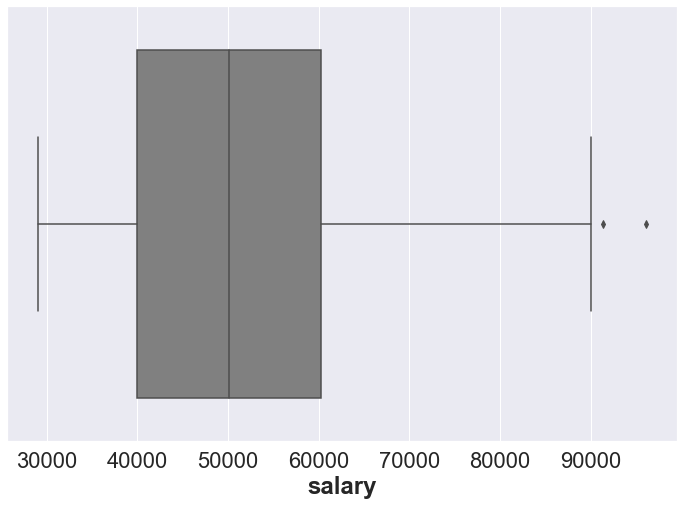

In [19]:
_ = sns.boxplot(x=df['salary'], color='grey')
plt.show()

We can already see from the boxplot that there are outliers but they will not necesarily affect our model, however it is necessary to transform this data for better results. Displayed below is the salary distribution before transformation.

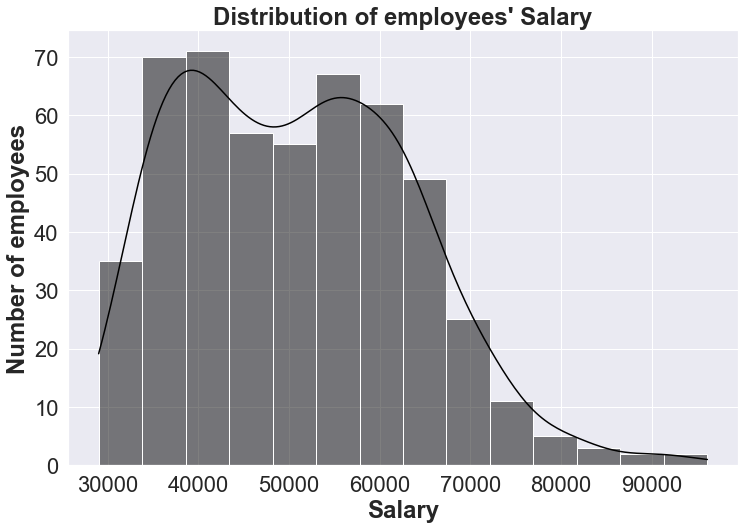

In [20]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(df1['salary'], kde=True, color='black')
ax.set(xlabel='Salary', ylabel='Number of employees', title="Distribution of employees' Salary")
plt.show()

This histogram shows a distribution that is positively skewed and is close to being a normal distribution. We want to log tranform the salary variable since we already know from the box plot that there are outliers, by doing so we will be able to have a better looking graph.

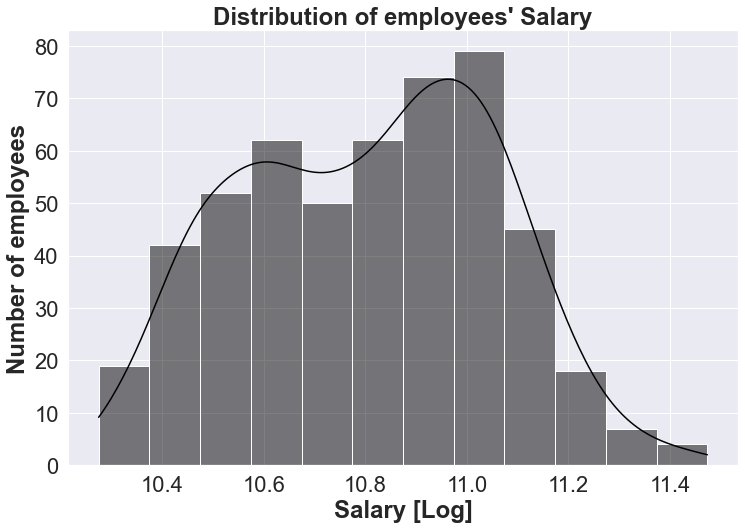

In [21]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(np.log(df1['salary']), kde=True, color='black')
ax.set(xlabel='Salary [Log]', ylabel='Number of employees', title="Distribution of employees' Salary")
plt.show()

We now have a better looking distribution of the transformed salary

### One-hot encoding.

In [22]:
df1['field'] = df1.field.map({1:'engineering', 2:'finance', 3:'human resources', 4:'marketing'})

In [23]:
df1['position'] = df1.position.map({1:'junior', 2:'manager', 3:'executive'})

### Features engineering (get dummies)

In [24]:
cat_columns = ['position', 'field']

In [25]:
df_processed = pd.get_dummies(df1, prefix_sep="_",
                              columns=cat_columns, drop_first=True)

In [26]:
df_processed.head()

,salary,yearsworked,yearsrank,position_junior,position_manager,field_finance,field_human resources,field_marketing
0,53000.0,0,0,1,0,0,1,0
1,58000.0,0,0,1,0,1,0,0
2,45500.0,0,0,1,0,0,1,0
3,35782.0,2,1,1,0,0,0,1
4,34731.0,2,2,1,0,0,0,1


We have now split the categorical features into their relative categories.

### Pearsonr

In [27]:
for feat in df_processed:
    if feat == 'salary':
        pass
    else:
        print(f"{feat} vs salary: {pearsonr(df_processed[feat],df_processed['salary'])}")

yearsworked vs salary: (0.6231354820920547, 1.274779518969558e-56)
yearsrank vs salary: (0.6105803925248937, 7.841461421299016e-54)
position_junior vs salary: (-0.5392884017436517, 4.027318255488322e-40)
position_manager vs salary: (-0.19712690041164913, 6.7142998270708735e-06)
field_finance vs salary: (0.2315530954300979, 1.1009877941612074e-07)
field_human resources vs salary: (-0.43567692232471955, 3.17711879491365e-25)
field_marketing vs salary: (-0.21629556535257666, 7.400704562098004e-07)


### Correlation matrix

Text(0.5, 1.0, 'Correlations to Salary')

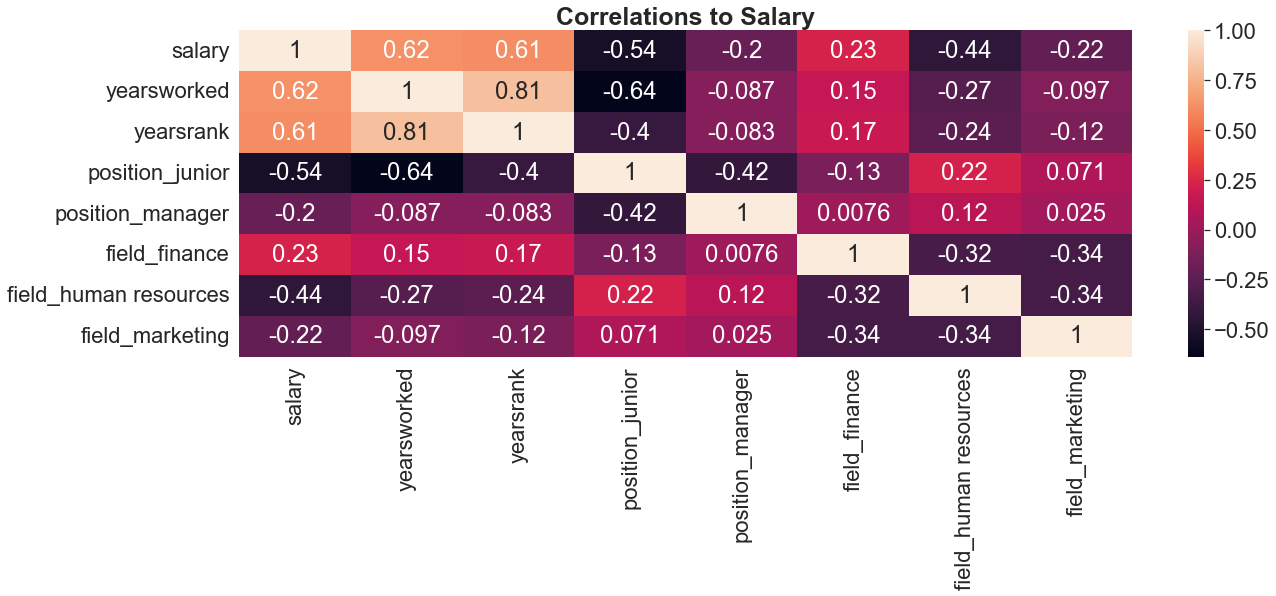

In [28]:
plt.figure(figsize=(20,6))
sns.heatmap(df_processed.corr(), cmap="rocket", annot=True)
plt.title('Correlations to Salary',size=25)

The one-hot encoded features do not seem have any effect on each other since their correlation values are below the statistical significance of 0.50 

Looking at the above results and from the correlation matrix we can see that there is multicollinearity, yearsworked and yearsrank are highly correlated with one another by a correlation value of 0.81, therefore we will go ahead and drop one of the characteristics to avoid multicollinearity since it weakens the statistical power of the regression model. However to make a better and informed decision on which characteristic/feature to drop, we will need to calculate the variation inflation factor (VIF).

#### Variation Inflation Factor (VIF)

In [29]:
VIF = pd.Series([variance_inflation_factor(df_processed.values, i) 
               for i in range(df_processed.shape[1])], index=df_processed.columns)
VIF

salary                    9.459559
yearsworked              13.375518
yearsrank                 7.132389
position_junior           2.850251
position_manager          2.012553
field_finance             1.940772
field_human resources     2.195209
field_marketing           2.059861
dtype: float64

We will decide which feature to drop according to the information below:
- VIF = 1 - No correlation
- VIF = 1 to 5 - Moderate correlation
- VIF > 10 - High correlation

Since we do see from the VIF results, yearsworked has a VIF value above 10, this solidifies a high correlation. Therefore we will go ahead and drop this feature.

In [30]:
df_processed.drop(['yearsworked'], axis=1, inplace=True)

### Splitting the dataset into training and test data

Setting response and predictor variables

In [31]:
X = df_processed.iloc[:,1:]
y = df_processed.iloc[:,:1]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [33]:
X_train.head()

,yearsrank,position_junior,position_manager,field_finance,field_human resources,field_marketing
237,17,0,1,1,0,0
79,0,1,0,0,1,0
477,9,0,1,0,1,0
226,10,0,0,0,0,0
69,1,0,1,0,0,1


In [34]:
y_train.head()

,salary
237,63409.00000
79,29000.00000
477,39574.00000
226,59534.85938
69,37500.00000


### Regression model

In [35]:
X_train = sm.add_constant(X_train)
const_model = sm.OLS(np.log(y_train), X_train)
const_results = const_model.fit()
print(const_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     169.8
Date:                Thu, 26 Jan 2023   Prob (F-statistic):          3.82e-107
Time:                        16:09:21   Log-Likelihood:                 242.03
No. Observations:                 411   AIC:                            -470.1
Df Residuals:                     404   BIC:                            -441.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.97

A positive coefficient indicates that as the predictor variable increases, the response variable also tends to increase. A negative coefficient indicates that as the predictor variable decreases, the response variable tends to decrease.

So since the yearsrank coefficient is 0.01, this means that for each additional yearsrank, salary is expected to increase by 0.01 units. Since all the remaining predictor variables have a negative coefficient, the response variable (salary) tends to decrease.  

### Most important features

In [36]:
const_results.params.sort_values(ascending=False)

const                    10.972560
yearsrank                 0.010531
field_finance            -0.054601
position_manager         -0.167690
field_marketing          -0.170942
field_human resources    -0.222201
position_junior          -0.280457
dtype: float64

### Evaluate model

#### Normalizing function

In [37]:
def normalize(value, average, col_range):
    x = (value - average)/col_range
    return x

#### Getting residuals and fitted values from the model

In [38]:
resids = const_results.resid
fitted = const_results.fittedvalues

#### Normalizing residuals

In [39]:
resids_range = resids.max()- resids.min()
resids_avg = resids.mean()
resids = resids.apply(normalize, args=(resids_avg, resids_range))

#### Normalizing the fitted values

In [40]:
fitted_range = fitted.max()- fitted.min()
fitted_avg = fitted.mean()
fitted = fitted.apply(normalize, args=(fitted_avg, fitted_range))

### Residual plot representation

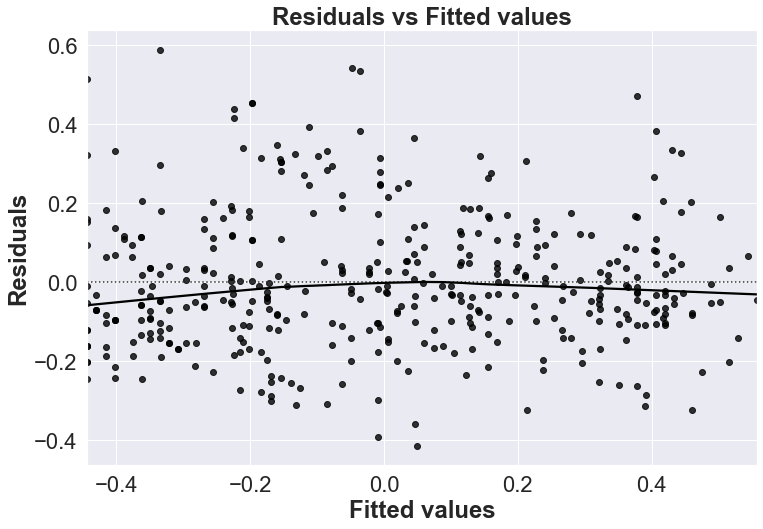

In [41]:
sns.residplot(x=fitted, y=resids, lowess=True, color='black')
plt.title("Residuals vs Fitted values")
plt.ylabel("Residuals")
plt.xlabel("Fitted values")
plt.show()

Added is the lowess line, which is the locally weighted smoothing line. The lowess line is a tool which creates a smooth line through the residual plot to help us see the relationship and trend between our features.There is no clear relationship in the plot, since the points are scattered (randomly dispersed) thus, the addition of the lowess line supports and suggests that a linear model is appropriate for the data. There are no problems with the regression.

In [42]:
round(sum(resids))

0

#### Fitting our model to the test set 

In [43]:
X_test = sm.add_constant(X_test)
preds = np.exp(const_results.predict(X_test))
preds

427    35238.767680
243    62710.036949
61     35238.767680
403    37881.653243
450    41519.858304
           ...     
496    44833.812696
137    44696.209120
102    42109.657489
212    61283.656326
216    36754.870733
Length: 103, dtype: float64

In [44]:
X_test['predicted salary'] = preds
X_test = X_test[['yearsrank','predicted salary']]
results = pd.concat([X_test,y_test], axis=1)
results.head()

,yearsrank,predicted salary,salary
427,0,35238.767680,43500.0
243,7,62710.036949,54686.0
61,0,35238.767680,29500.0
403,2,37881.653243,55752.0
450,0,41519.858304,63500.0


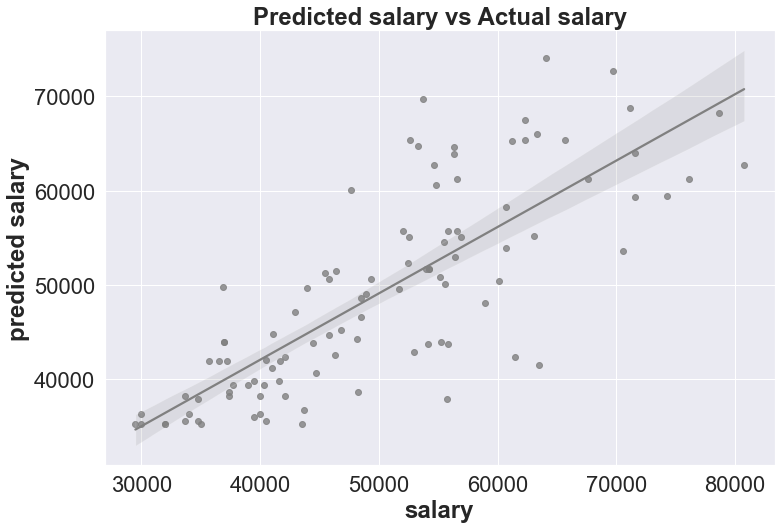

In [45]:
sns.regplot(x=results[['salary']], y=results[['predicted salary']], color='grey')
plt.title('Predicted salary vs Actual salary')
plt.show()

This model works well since it predicts a bit closely at lower salaries but starts to spread out as it moves up to higher salaries

### Cross Validation

In [46]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, np.log(y), scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print(f'The MAE is: {np.mean(np.absolute(scores))}')

The MAE is: 0.10713880591312312


The lower the MAE, the more closely a model is able to predict the actual observations, we can already tell from the results that the MAE is very low at 0.10

In [47]:
predicted_salary = np.exp(const_results.predict(X_train))
X_train['predicted salary'] = predicted_salary

In [48]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, predicted_salary))
print(f'test RMSE: {test_rmse}')
print(f'train RMSE: {train_rmse}')
print(f'difference: {test_rmse - train_rmse}')

test RMSE: 7383.825249879978
train RMSE: 7054.2240710241185
difference: 329.60117885585987


There is a very small difference between the test and train RMSE, which means we can trust our model to predict the unknown values. The splits have worked well in preventing overfitting and underfitting.

### Conclusion

- This model is a good one since it has an R squared value of 0.7
- There is a Linear relationship in this model
- There are no existing auto-correlations looking at the Durbins_Watsons value of 2 
- There is no multicollinearity since it was taken care of
- There is multivariate normality